In [1]:
!pip install git+https://git.astron.nl/astron-sdc/esap-userprofile-python-client.git
!pip install astropy[all]==4.3.1 reproject

  Cloning https://git.astron.nl/astron-sdc/esap-userprofile-python-client.git to /tmp/pip-req-build-f6q7gpy5
  Running command git clone -q https://git.astron.nl/astron-sdc/esap-userprofile-python-client.git /tmp/pip-req-build-f6q7gpy5


In [2]:
from rucio.client import Client
from rucio_jupyterlab.kernels.ipython.types import SingleItemDID as sid
from os import environ

MY_RSE = environ['RUCIO_DESTINATION_RSE']
def make_available(scope, name, **kwargs):
   rcli = Client()
   try:
      rcli.add_replication_rule(dids=[{"scope": scope, "name": name}],
                               copies=1,
                               rse_expression=MY_RSE,
                               lifetime=604800,
                               purge_replicas=True)
   except:  ## Needs cleanup but this exception is hard to import...
      pass
   while True:
        replicadata = list(rcli.list_replicas(dids=[{"scope": scope, "name": name}],
                                                  rse_expression=MY_RSE))[0]['rses']
        if replicadata:
            replicadress = replicadata[MY_RSE][0]
            break
   return sid(replicadress.replace("root://eoseulake.cern.ch:1094//eos/eulake/tests/rucio_test", "/eos"))  

In [3]:
from shopping_client import shopping_client
from samp import samp_connector
from rucio_cli import rucio_connector
sac = samp_connector()
ruc = rucio_connector()
sc = shopping_client(host="https://sdc-dev.astron.nl", connectors=[sac, ruc])

In [4]:
my_data = sc.get_basket(convert_to_pandas=True,filter_archives=True)
my_data['rucio']['record'][0]

{'scope': 'LOFAR_ASTRON_PANDEY',
 'name': 'UseCase2_Imageset_3C196IBL_SB000_SB031_Set1-2-3',
 'type': 'DATASET',
 'parent': None,
 'level': 0,
 'bytes': None}

In [5]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)
fitsfile = make_available(**my_data['rucio']['record'][0])

In [6]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
import numpy as np
import matplotlib

durls = [d[13] for d in my_data['samp']['record']]
#durls = list()
#for bb in bask:
#    if bbdat['archive'] == 'samp':
#        daturl=bbdat['record'][13]
#        durls.append(daturl)  

In [7]:
mainhdu = fits.open(durls[0])[0]
maindata = mainhdu.data
mainhead = mainhdu.header

for dat in durls[1:2]:
    myhdu = fits.open(dat)[0]
    mydata = reproject_interp(myhdu, mainhead, return_footprint=False) # Not sure if this is needed because it doesn't change much...
    maindata += mydata

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
WCS Keywords

Number

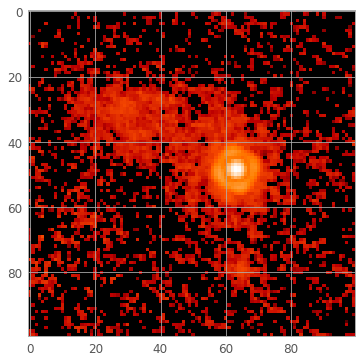

In [8]:
from astropy.nddata import Cutout2D

position = (410,340)
size = (100, 100)     # pixels
cutout = Cutout2D(maindata, position, size, wcs=WCS(mainhead))
plt.imshow(cutout.data, norm=matplotlib.colors.PowerNorm(vmin=0.1, gamma=0.1))
print(cutout.wcs)

Text(0.99, 0.01, 'Data courtesy of LOFAR EOR project')

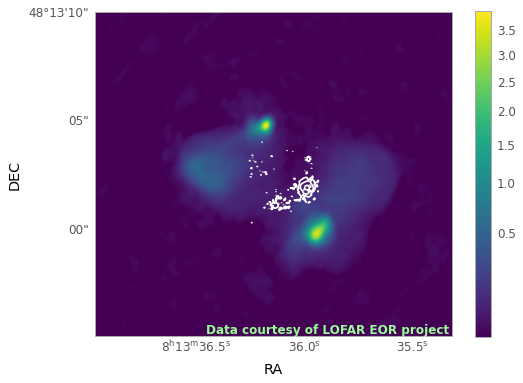

In [9]:
image_file = get_pkg_data_filename(fitsfile)
hdu = fits.open(image_file)[0]
wcs = WCS(hdu.header).slice((0,0))
image_data = hdu.data[0][0]
fifi = plt.figure()
ax = plt.subplot(projection=wcs)
fig = plt.imshow(image_data, cmap='viridis', norm=matplotlib.colors.PowerNorm(vmin=0.005, gamma=0.55))
hdupcts_x = hdu.data.shape[2] / 100.
hdupcts_y = hdu.data.shape[3] / 100.
minx, maxx = int(hdupcts_x*20), int(hdupcts_x*75)
miny, maxy = int(hdupcts_y*25), int(hdupcts_y*75)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.grid()
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
fifi.colorbar(fig, ax=ax)
ax.contour(cutout.data, levels=np.logspace(-0.3,2, 4), colors='white', transform=ax.get_transform(cutout.wcs))
plt.text(0.99,0.01,"Data courtesy of LOFAR EOR project",color="palegreen", ha='right', fontweight="bold",transform=ax.transAxes)

In [10]:
import subprocess as SP
figname = "/scratch/grange/3C96_LOFAR_HST_overlay_final.png"
myscope = "LOFAR_ASTRON_PANDEY"
plt.savefig(figname)
ruleinfo = SP.getoutput(f"datalake upload --rse 'QOS=OPPORTUNISTIC' -s {myscope} -t 5 {figname}").split("\n")

<Figure size 576x432 with 0 Axes>

In [11]:
fname, ruleid, ruleurl = ruleinfo[6].split()
print(f"Rule {ruleid} for file {fname}, please click here for the rucio UI: {ruleurl}")

Rule ec3092427bc140e8955af54ddeb992ff for file LOFAR_ASTRON_PANDEY:3C96_LOFAR_HST_overlay_final.png, please click here for the rucio UI: https://escape-rucio-webui.cern.ch/rule?rule_id=ec3092427bc140e8955af54ddeb992ff
